In [1]:
import os, time, socket, glob

# print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
# print("【工作目錄】{}".format(os.getcwd()))
# print("【主機名稱】{} {}".format(socket.gethostname(), 
#                            socket.gethostbyname(socket.gethostname())))

# Read data

In [2]:
from python_speech_features import mfcc, delta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa

In [3]:
class WaveReader:
    def __init__(self, path, sample_rate, padding_type, read_size):
        '''
        Args:
            path: train path containing directory which one would like to load
            sample_rate: sample rate for reading .wav file
            padding_type: padding for .wav data length less than 1 second
            read_size: size that one would like to read
        '''
        
        self.path = path
        self.sample_rate = sample_rate
        self.padding_type = padding_type
        self.read_size = read_size

    def read(self, labels=None):
        '''
        read all the data under the labels(directories) one select
        
        Args:
            labels: labels(directories) one would like to load
                    None means read all the directories under that directory
        '''
        print("LABEL\tTOTAL\tREAD\tSAVED\t<1s COUNT")
        print("-----\t-----\t----\t-----\t---------")
        
        if labels is None:
            labels = [f for f in os.listdir(path) if os.path.isdir(path + "\\" + f)]
            
        elif type(labels) == str:
            samples, total_wave_count, total_wave_read, total_loss_count = self.read_dir(dir_name=labels)
            sample_labels = np.repeat(labels, total_wave_read)
            
            print("\nMISSION COMPELTE!!!")
            return samples, sample_labels, total_wave_count, total_loss_count
                    
        label_len = len(labels)
        total_wave_count = np.zeros(label_len, dtype=np.int32)
        total_wave_read = np.zeros(label_len, dtype=np.int32)
        total_loss_count = np.zeros(label_len, dtype=np.int32)

        
        for i, lab in enumerate(labels):
            samp, total_wave_count[i], total_wave_read[i], total_loss_count[i] = self.read_dir(dir_name=lab)
            
            if i == 0:
                samples = samp
                sample_labels = np.repeat(lab, total_wave_read[i])
            else:
                samples = np.concatenate((samples, samp), axis=0)
                sample_labels = np.concatenate((sample_labels, np.repeat(lab, total_wave_read[i])), axis=None)
        
        print("\nMISSION COMPELTE!!!")
        return samples, sample_labels, total_wave_count, total_loss_count
    
    def read_dir(self, dir_name):
        '''
        read one directory of given directory name
        
        Args:
            dir_name: directory name
        '''
        dir_path = os.path.join(self.path, dir_name)
        wave_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
        total_wave_files = len(wave_files)

        if self.read_size is not None:
            wave_files_read = self.read_size
        else:
            wave_files_read = total_wave_files

        samples = np.zeros((wave_files_read, self.sample_rate))
        less_than_1s_count = 0
        num_of_file_read = 0
        for i, wav_file in enumerate(wave_files):
            wave_file_path = os.path.join(dir_path, wav_file)
            samp, _ = librosa.load(wave_file_path, sr=self.sample_rate)

            pad_size = self.sample_rate - len(samp)
            if pad_size > 0:
                less_than_1s_count += 1
                if self.padding_type is None:
                    # None: than skip this wave file
                    continue

                elif self.padding_type == "white_noise":
                    # white_noise: pad white noise data behind
                    padding = np.random.normal(0, 0.02, pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1


                elif self.padding_type == "zero":
                    # zero: pad zeros behind
                    padding = np.zeros(pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1
            else:
                samples[num_of_file_read, :] = samp
                num_of_file_read += 1

            print("{}\t{}\t{}\t{}\t{}".format(dir_name, 
                                              total_wave_files, 
                                              i+1, 
                                              num_of_file_read, 
                                              less_than_1s_count), end="\r")
            
            if num_of_file_read == wave_files_read:
                break
                
        print()

        return samples, total_wave_files, wave_files_read, less_than_1s_count

In [4]:
SAMPLE_RATE = 16000

train_audio_path = os.path.join(os.path.dirname(os.getcwd()), "data", "train", "audio")
phoneme_path = os.path.join(os.getcwd(), "Phonemes")
phoneme_dataframe = pd.read_csv(os.path.join(phoneme_path, "phonemes.csv"))

reader = WaveReader(path=train_audio_path, 
                    sample_rate=SAMPLE_RATE, 
                    padding_type=None, 
                    read_size=2000)

wav_array, label_array, total, loss = reader.read(labels=phoneme_dataframe.words)

print()
print(f"NaN Number: {np.sum(np.isnan(wav_array))}")
print(f"Inf Number: {np.sum(np.isinf(wav_array))}")

LABEL	TOTAL	READ	SAVED	<1s COUNT
-----	-----	----	-----	---------
zero	2376	2160	2000	160
one	2370	2262	2000	262
two	2373	2222	2000	222
three	2356	2207	2000	207
four	2372	2201	2000	201
five	2357	2185	2000	185
six	2369	2164	2000	164
seven	2377	2194	2000	194
eight	2352	2232	2000	232
nine	2364	2178	2000	178

MISSION COMPELTE!!!

NaN Number: 0
Inf Number: 0


In [5]:
def apply_mfcc(inputs, sample_rate):
    input_length = len(inputs)
    sample_shape = mfcc(inputs[0], sample_rate, appendEnergy=True).shape
    outputs = np.zeros(((input_length, sample_shape[0], sample_shape[1]*3)))
    print(f"Outputs Shape: (input size, time step, featured) {outputs.shape}\n")
    
    for i in range(input_length):
        print(f"Applying MFCC transformation to {i+1}th wave array", end="\r")
        mfcc_feat = mfcc(inputs[i, :], sample_rate, appendEnergy=True).T

        d_mfcc_feat = delta(mfcc_feat, 2)
        mfcc_features = np.concatenate((mfcc_feat.T, d_mfcc_feat.T), axis=1)
        
        dd_mfcc_feat = delta(d_mfcc_feat, 2)
        mfcc_features = np.concatenate((mfcc_features, dd_mfcc_feat.T), axis=1)
        
        outputs[i, :, :] = mfcc_features
        
    print("\n\nMISSION COMPELTE!!!")
    return outputs

In [6]:
mfcc_wav_array = apply_mfcc(wav_array, sample_rate=SAMPLE_RATE)

Outputs Shape: (input size, time step, featured) (20000, 99, 39)

Applying MFCC transformation to 20000th wave array

MISSION COMPELTE!!!


In [7]:
shape = mfcc_wav_array.shape
flattened_wav_array = mfcc_wav_array.reshape(-1, shape[1]*shape[2])
print(f"Flattened MFCC Wave Shape: {flattened_wav_array.shape}")

Flattened MFCC Wave Shape: (20000, 3861)


# Preprocess

In [8]:
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC

from scikitplot.metrics import plot_confusion_matrix

train_x, test_x, train_y, test_y = train_test_split(flattened_wav_array, label_array, test_size = 0.2)

### PCA

In [9]:
pca = PCA(n_components = .945).fit(train_x)
pca_train = pca.transform(train_x)
pca_test = pca.transform(test_x)

print(f"PCA Output Shape: {pca_train.shape}")

PCA Output Shape: (16000, 348)


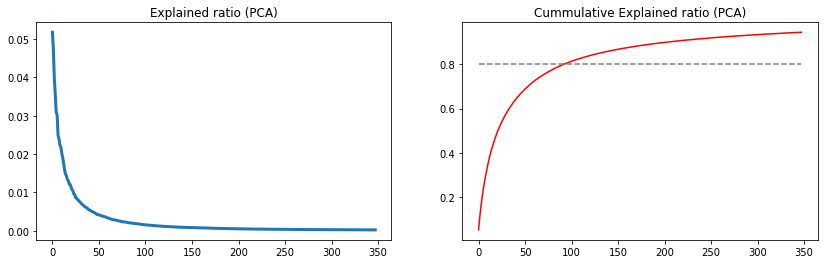

In [10]:
x = range(pca.n_components_)
y = pca.explained_variance_ratio_

plt.figure(figsize = (14, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y, linewidth=3)
plt.title("Explained ratio (PCA)")

plt.subplot(1, 2, 2)
plt.plot(x, np.cumsum(y), color="red")
plt.plot(x, np.repeat(0.8, len(x)), color="gray", linestyle="--")
plt.title("Cummulative Explained ratio (PCA)")

plt.show()

# Classification

### PCA + LDA

In [11]:
print(f"Input Shape:  {pca_train.shape}")
print(f"Target Shape: {train_y.shape}")

Input Shape:  (16000, 348)
Target Shape: (16000,)


In [12]:
start = time.time()
lda = LDA(n_components=9).fit(pca_train, train_y)
lda_time_consumed = (time.time() - start)
print("Time consumed for fitting: {:.2f}".format(lda_time_consumed))
lda_train = lda.transform(pca_train)
lda_test = lda.transform(pca_test)

lda_pred = lda.predict(pca_test)
lda_acc = metrics.accuracy_score(test_y, lda_pred)
print("LDA Accuracy: {:.2f}%".format(lda_acc*100))

Time consumed for fitting: 0.77
LDA Accuracy: 61.72%


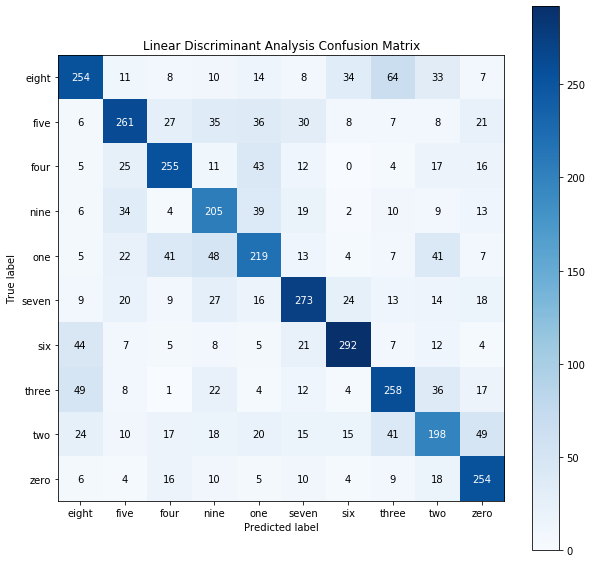

In [13]:
plot_confusion_matrix(y_true=lda_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Linear Discriminant Analysis Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### PCA + KNN

In [14]:
# PCA KNN model
for i in range(1, 11):
    knn = KNN(n_neighbors=i).fit(pca_train, train_y)

    # 預測
    knn_pred = knn.predict(pca_test)

    # 績效
    knn_acc = metrics.accuracy_score(test_y, knn_pred)
    print("KNN k = {} Accuracy: {:.2f}%".format(i, knn_acc*100))

KNN k = 1 Accuracy: 79.88%
KNN k = 2 Accuracy: 75.50%
KNN k = 3 Accuracy: 79.65%
KNN k = 4 Accuracy: 79.45%
KNN k = 5 Accuracy: 80.65%
KNN k = 6 Accuracy: 81.23%
KNN k = 7 Accuracy: 81.75%
KNN k = 8 Accuracy: 81.80%
KNN k = 9 Accuracy: 82.35%
KNN k = 10 Accuracy: 82.23%


In [15]:
# LDA KNN model
for i in range(1, 11):
    knn = KNN(n_neighbors=i).fit(lda_train, train_y)

    # 預測
    knn_pred = knn.predict(lda_test)

    # 績效
    knn_acc = metrics.accuracy_score(test_y, knn_pred)
    print("KNN k = {} Accuracy: {:.2f}%".format(i, knn_acc*100))

KNN k = 1 Accuracy: 53.73%
KNN k = 2 Accuracy: 52.90%
KNN k = 3 Accuracy: 56.65%
KNN k = 4 Accuracy: 58.17%
KNN k = 5 Accuracy: 59.00%
KNN k = 6 Accuracy: 59.72%
KNN k = 7 Accuracy: 60.52%
KNN k = 8 Accuracy: 60.90%
KNN k = 9 Accuracy: 61.15%
KNN k = 10 Accuracy: 61.22%


In [16]:
# 建立 knn 模型
start = time.time()
knn = KNN(n_neighbors=8).fit(pca_train, train_y)
knn_time_consumed = (time.time() - start)
print("Time consumed for fitting: {:.2f}".format(knn_time_consumed))

# 預測
knn_pred = knn.predict(pca_test)

# 績效
knn_acc = metrics.accuracy_score(test_y, knn_pred)
print("KNN Accuracy: {:.2f}%".format(knn_acc*100))

Time consumed for fitting: 1.37
KNN Accuracy: 81.80%


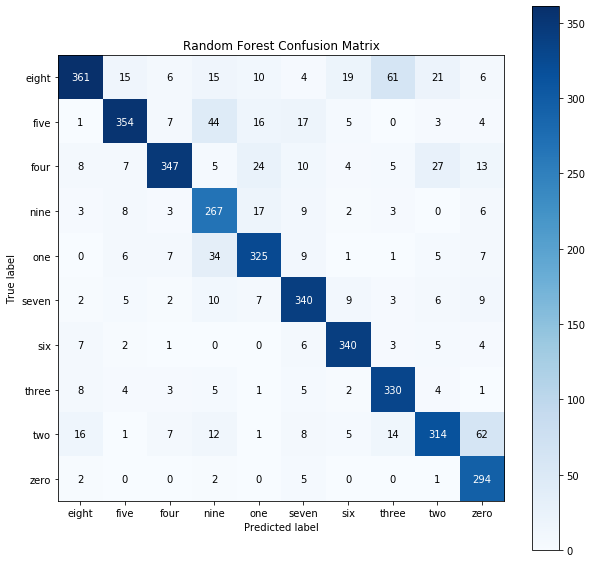

In [17]:
plot_confusion_matrix(y_true=knn_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Random Forest Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### PCA + Random Forest

In [18]:
# 建立 random forest 模型
start = time.time()
rf = RF(n_estimators = 180).fit(pca_train, train_y)
rf_time_consumed = (time.time() - start)
print("Time consumed for fitting: {:.2f}".format(rf_time_consumed))

# 預測
rf_pred = rf.predict(pca_test)

# 績效
rf_acc = metrics.accuracy_score(test_y, rf_pred)
print("Random Forest Accuracy: {:.2f}%".format(rf_acc*100))

Time consumed for fitting: 43.86
Random Forest Accuracy: 72.58%


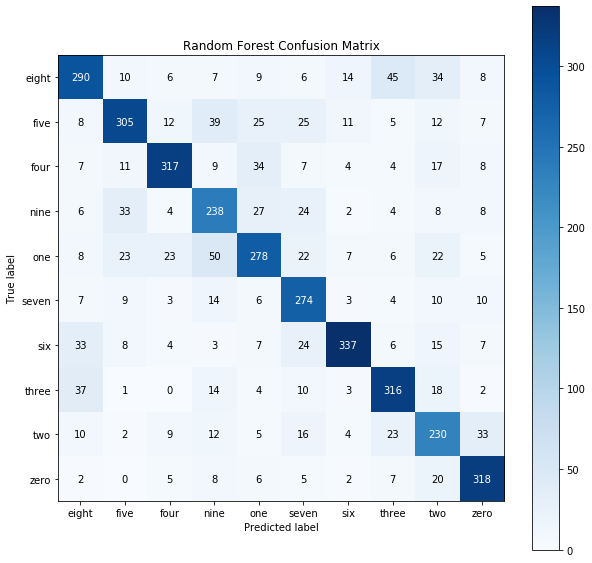

In [19]:
plot_confusion_matrix(y_true=rf_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Random Forest Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### PCA + SVM

In [20]:
start = time.time()
svm = SVC().fit(pca_train, train_y)
svm_time_consumed = (time.time() - start)
print("Time consumed for fitting: {:.2f}".format(svm_time_consumed))
svm_pred = svm.predict(pca_test)

svm_acc = metrics.accuracy_score(test_y, svm_pred)
print("SVM Accuracy: {:.2f}%".format(svm_acc*100))

Time consumed for fitting: 82.74
SVM Accuracy: 86.48%


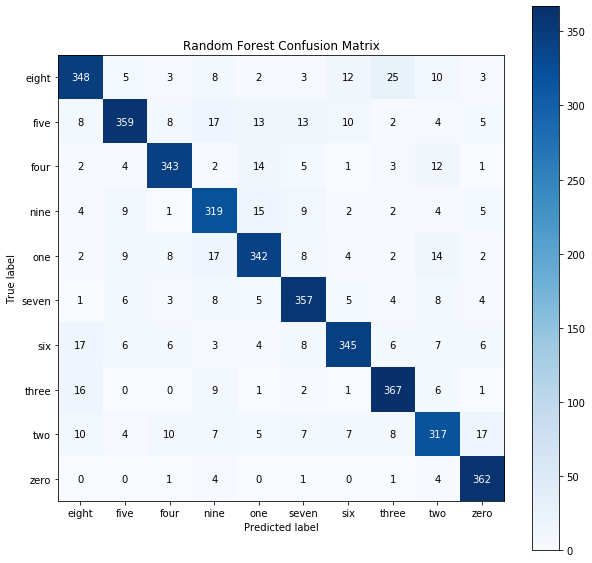

In [21]:
plot_confusion_matrix(y_true=svm_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Random Forest Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

In [59]:
print("     Models Comparation")
print("-----------------------------")
print("{:6}{:>10}{:>12}".format("Model", "Acc", "Time"))
print("=============================")
print("{:6}    {:>.4f}  {:>10}".format("LDA", lda_acc, "{:.4f}".format(lda_time_consumed)))
print("{:6}    {:>.4f}  {:>10}".format("RF",  rf_acc,  "{:.4f}".format(rf_time_consumed)))
print("{:6}    {:>.4f}  {:>10}".format("KNN", knn_acc, "{:.4f}".format(knn_time_consumed)))
print("{:6}    {:>.4f}  {:>10}".format("SVM", svm_acc, "{:.4f}".format(svm_time_consumed)))
print("-----------------------------")

     Models Comparation
-----------------------------
Model        Acc        Time
LDA       0.6172      0.7670
RF        0.7258     43.8586
KNN       0.8180      1.3705
SVM       0.8648     82.7351
-----------------------------


### MLP

In [23]:
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")
print()
print(f"GPU available: {tf.test.is_gpu_available()}")
print(f"CUDA enabled: {tf.test.is_built_with_cuda()}")

Tensorflow Version: 2.0.0

GPU available: True
CUDA enabled: True


In [24]:
BATCH_SIZE = 1
EPOCHS = 10

data_shape = mfcc_wav_array.shape
input_shape = (data_shape[1], data_shape[2])

print(f"Input Shape: (input size, time step, features) {data_shape}")
print(f"Input Layer: (batch size, time step, features) {input_shape}")

Input Shape: (input size, time step, features) (20000, 99, 39)
Input Layer: (batch size, time step, features) (99, 39)


In [25]:
le = LabelEncoder().fit(phoneme_dataframe.words)
print(f"Labels: {le.classes_}")

targets = le.transform(label_array)
train_x, test_x, train_y, test_y = train_test_split(mfcc_wav_array, targets, test_size = 0.2, shuffle=True)

Labels: ['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


In [26]:
def AccLossPlot(TrainHistory):    
    acc = TrainHistory.history['accuracy']
    val_acc = TrainHistory.history['val_accuracy']

    loss = TrainHistory.history['loss']
    val_loss = TrainHistory.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [27]:
DROPOUT_RATIO = 0.2
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=input_shape, batch_size=1),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=64, padding="same", kernel_size=3, activation="relu"),     
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(DROPOUT_RATIO),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=128, padding="same", kernel_size=3, activation='relu'), 
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    
    # BLSTM layer
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)), 
    tf.keras.layers.Flatten(),
    
    # output layer
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(DROPOUT_RATIO),
    tf.keras.layers.Dense(10, activation="softmax")    
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (1, 99, 64)               7552      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (1, 33, 64)               0         
_________________________________________________________________
batch_normalization (BatchNo (1, 33, 64)               256       
_________________________________________________________________
dropout (Dropout)            (1, 33, 64)               0         
_________________________________________________________________
conv1d_1 (Conv1D)            (1, 33, 128)              24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (1, 11, 128)              0         
_________________________________________________________________
flatten (Flatten)            (1, 1408)                 0

In [28]:
history = model.fit(train_x, train_y, 
                    epochs=EPOCHS, 
                    validation_data=(test_x,  test_y), 
                    shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 1.0418 - accuracy: 0.6398 - val_loss: 0.6288 - val_accuracy: 0.8372
Epoch 2/10
16000/16000 [==============================] - 62s 4ms/sample - loss: 0.3707 - accuracy: 0.8876 - val_loss: 0.6691 - val_accuracy: 0.8618
Epoch 3/10
16000/16000 [==============================] - 62s 4ms/sample - loss: 0.3041 - accuracy: 0.9104 - val_loss: 0.4859 - val_accuracy: 0.8735
Epoch 4/10
16000/16000 [==============================] - 62s 4ms/sample - loss: 0.2685 - accuracy: 0.9227 - val_loss: 0.9056 - val_accuracy: 0.8687
Epoch 5/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 0.2453 - accuracy: 0.9299 - val_loss: 0.8067 - val_accuracy: 0.8813
Epoch 6/10
16000/16000 [==============================] - 62s 4ms/sample - loss: 0.2409 - accuracy: 0.9309 - val_loss: 0.7156 - val_accuracy: 0.8810
Epoch 7/10
16000/16000 [==============================] -

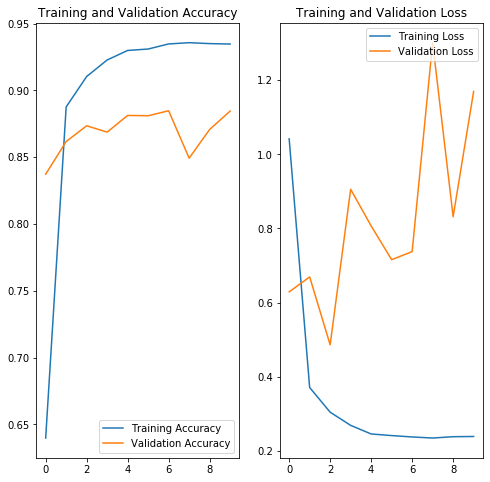

In [29]:
AccLossPlot(history)